In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("D:\\watanabe\\lib")
sys.path.append("D:\\watanabe\\lib\\sequence_parser")
sys.path.append("D:\\watanabe\\lib\\sqe_fitting")
sys.path.append("D:\\watanabe\\lib\\qcodes_drivers")
sys.path.append("D:\\watanabe\\lib\\measurement_codes_ut")

In [3]:
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm

# Create session

In [4]:
from measurement_tool.session import SessionManager as Session
from measurement_tool.datataking.time_domain import TimeDomainInstrumentManager as TDM

In [5]:
session = Session(
    cooling_down_id='CDY145', 
    experiment_username="Watanabe", 
    sample_name="DPR1-l-120-44")

# Create TDM - instrument manager

In [6]:
tdm = TDM(session, trigger_address="PXI0::1::BACKPLANE", save_path="D:/watanabe/data")

Creating a new insturment management class for timedomain measurement...done


## Set wiring information text

In [7]:
wiring = "\n".join([
    "readout",
    "E8257D(lo1) - 1500mm - LO2",
    "M3202A_slot2_ch1 - 500mm - 10dB - IFin2",
    "RFout2 - 1000mm - 20dB - F-19480 - In1D",
    "Out2A - Miteq - 1500mm - RFin1",
    "IFout1 - 500mm - DCblock - M3102A_slot9_ch1",

    "drive_line",
    "N5173B - 2000mm - LO#4",
    "M3202A_slot2_ch2 - 500mm - 10dB - IFin4",
    "RFout#4 - 1500mm - 10dB - In1C"
])

tdm.set_wiring_note(wiring)

## Add control line information

In [8]:
# For readout line
tdm.add_readout_line(
    port_name="readout",
    lo_address="TCPIP0::192.168.100.5::inst0::INSTR",
    lo_power=24,
    awg_chasis=1,
    awg_slot=2,
    awg_channel=1,
    dig_chasis=1,
    dig_slot=9,
    dig_channel=1,
    IQ_corrector=None,
    if_freq=125e6,
    sideband='lower'
)

# For qubit control line
tdm.add_qubit_line(
    port_name="qubit",
    lo_address="TCPIP0::192.168.100.9::inst0::INSTR",
    lo_power=18,
    awg_chasis=1,
    awg_slot=2,
    awg_channel=2,
    IQ_corrector=None,
    if_freq=150e6,
    sideband='lower'
)


# tdm.add_current_source_bias_line(port_name='readout_bias', current_source_address="TCPIP0::192.168.100.96::inst0::INSTR")

# You can also use add_misc_control_line for e-f, fogi, cloaking etc.

# Main

In [9]:
from sequence_parser import Sequence
from sequence_parser.instruction import *

In [10]:
readout_freq = 9.23e9
qubit_freq = 8.025e9
num_shot = 1000
tdm.set_acquisition_mode(averaging_waveform=True, averaging_shot=True)
tdm.set_shots(num_shot)
tdm.set_repetition_margin(100e3)

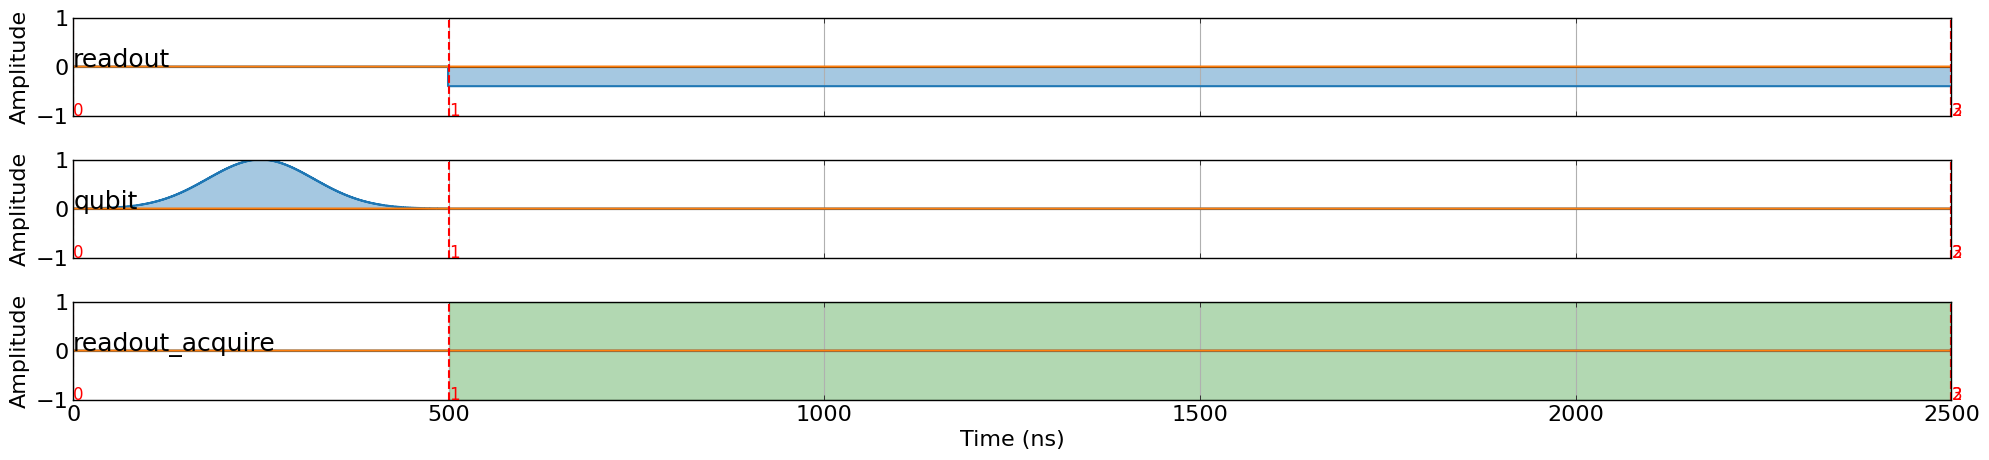

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.54it/s]


In [17]:
readout_port = tdm.port['readout'].port
qubit_port = tdm.port['qubit'].port
acq_port = tdm.acquire_port['readout_acquire']

tdm.port['readout'].frequency = readout_freq
tdm.port['qubit'].frequency = qubit_freq
ports = [readout_port, qubit_port, acq_port]

dur_range = np.linspace(10, 500, 40, dtype=int)
qubit_amplitude = 1.0
readout_amplitude = 0.4

sequences = []
for dur in dur_range:
    seq = Sequence(ports)
    if dur % 2 != 0:
        seq.add(Delay(1), qubit_port)
    seq.add(Gaussian(amplitude=qubit_amplitude, fwhm=dur/3, duration=dur), qubit_port)
    seq.trigger(ports)
    seq.add(ResetPhase(phase=0), readout_port, copy=False)
    seq.add(Square(amplitude=readout_amplitude, duration=2000), readout_port)
    seq.add(Acquire(duration=2000), acq_port)

    seq.trigger(ports)
    sequences.append(seq)
            
seq.draw()

data = DataDict(
            time=dict(unit="ns"),
            s11=dict(axes=["time"]),
        )
data.validate()

with DDH5Writer(data, tdm.save_path, name='Rabi') as writer:
    tdm.prepare_experiment(writer, 'tdm_test.ipynb')
    for i, seq in enumerate(tqdm(sequences)):
        raw_data = tdm.run(
            seq, as_complex=True)
        writer.add_data(
            time=dur_range[i],
            s11=raw_data['readout'],
        )

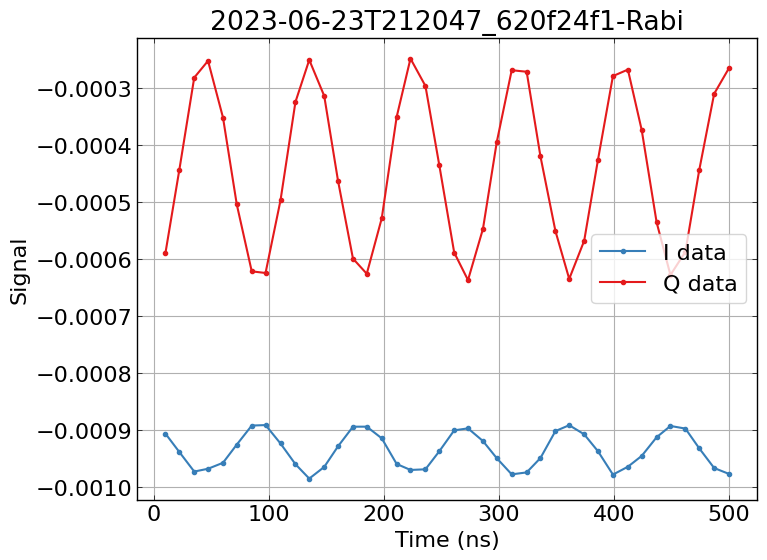

In [18]:
files = os.listdir(tdm.save_path)
date = files[-1] + '/'
files = os.listdir(tdm.save_path+date)
data_path = files[-1]

data_path_all = tdm.save_path+date+data_path + '/'

dataset = datadict_from_hdf5(data_path_all+"data")

from measurement_codes_ut.helper.plot_helper import PlotHelper

time = dataset['time']['values']
cplx = dataset['s11']['values']

plot = PlotHelper(title=data_path)
plot.plot(time, cplx.real, label='I')
plot.plot(time, cplx.imag, label='Q')
plot.label("Time (ns)", "Signal")
plt.legend()
plt.show()